In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import sys

In [2]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
l=[6562.8,6548,6583,6717,6731]#AngstromsR
#l=[4861.36,4958.9,5006.9]#AngstromsB
#LimitData
min0=65
max0=145

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

In [3]:
inputf='604.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})

mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

In [4]:
for i in 0,2:
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-l[Nx])/l[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('data'+str(int(l[Nx]))+'.csv')


In [5]:
datap='data6562.csv'

In [6]:
Ha=pd.read_csv(datap)
Ha=Ha.rename(columns={'Unnamed: 0':'No'})
Ha=Ha.drop('No',axis=1)
os.remove(datap)
Ha.describe()

,X,Y,RV,I
count,600.000000,600.000000,600.000000,600.000000
mean,105.269000,9.390000,-250.043594,2277.239467
std,23.243169,6.256047,10.420092,3750.107456
min,65.710000,0.000000,-277.593319,27.150000
25%,85.485000,4.000000,-257.836471,281.925000
50%,105.270000,9.000000,-249.888052,1017.500000
75%,125.045000,15.000000,-244.018098,2403.500000
max,144.830000,19.600000,-205.463695,30960.000000


In [7]:
#sosf

In [8]:
data=Ha.copy()

pc=1.0


df1=abs(data)#abs(data)?
df1n=df1.to_numpy()

xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

In [9]:
sig2=2*(data.RV.var())
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

In [10]:
a=[[0]*(l) for i in range(l)]
b=[[0]*(l) for i in range(l)]
c=[[0]*(2) for i in range(l*l)]

#Second Order Structure Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(((f[j][0])-(f[i][0]))**2)

#Normalized Second Order Structure Function Matrix [LxL]
#for i in range(l):
#    for j in range(l):
#        if i > j:
#            a[i][j]=(((f[j][0]-fm)-(f[i][0]-fm))**2)/(fv)

#Coord Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5
 
#LxL to Lx2
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]


In [11]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,1])>0.0
e=d[ind]
#Pandas Stuff
df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,179450.000000,179450.000000
mean,28.999527,217.459169
std,17.838110,332.028858
min,1.340000,0.002087
25%,14.667409,20.867147
50%,25.446611,95.563185
75%,41.359556,274.964306
max,81.511560,5202.682579


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


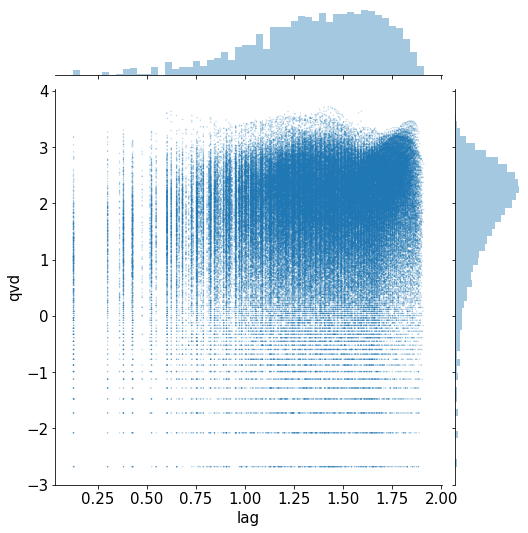

In [12]:
ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
ax.fig.set_size_inches(8,8)

In [13]:
#Main Filter Group
m=df.lag[1]-df.lag[0]#Lag step
n=int(df.lag.max()//df.lag.min())-1#Number of points
#Grouping points
dfx=dict()
for i in range(n):
    p=0+i*(m+0.001)#rs
    q=m+i*m
    dfx[i]=df[df['lag'].between(p,q)]
    
dfx

{0:          lag        qvd
 0       1.34   0.920241
 598     1.34   9.367262
 1196    1.34  57.501510
 2388    1.34  27.118944
 2983    1.34   4.415488
 ...      ...        ...
 179423  1.34   0.169024
 179436  1.34   0.920241
 179441  1.34   0.033387
 179447  1.34   0.834686
 179449  1.34   2.856712
 
 [527 rows x 2 columns], 1:              lag         qvd
 1       2.680000   16.159518
 59      2.300000   48.211456
 60      2.661879    8.547183
 599     2.680000  113.285653
 656     2.661879   62.453283
 ...          ...         ...
 179430  1.350000    1.754927
 179437  2.680000    0.603061
 179442  2.680000    0.033387
 179445  2.680000    0.834686
 179448  2.680000    6.779736
 
 [1937 rows x 2 columns], 2:              lag         qvd
 2       4.020000  134.626484
 61      3.531629    3.858335
 659     3.531629  349.067717
 1197    2.690000  306.098089
 1252    3.531629  120.194765
 ...          ...         ...
 179424  2.690000    0.834686
 179431  2.690000    5.216787
 179438 

Main Matrix Statistical Properties Groups

In [14]:
lgp=dict()
lpc=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    lpc[i]=lgp[i]*pc
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/np.sqrt(dl[i]-1)
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/np.sqrt(dl[i]-1)  


g=[[0]*(8) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=dfs[i]
    g[i][4]=dfv[i]
    g[i][5]=lpc[i]
    g[i][6]=dl[i]
    g[i][7]=derx[i]


mx=[row[0] for row in g]
nx=[row[1] for row in g]
o=[row[2] for row in g]
mpc=[row[5] for row in g]

Power law calculation.

In [15]:
#Exponent

xa=[mx]
xe=list(map(list, zip(*xa)))
ya=[nx]
ye=list(map(list, zip(*ya)))

L=len(xe)

me=[[0]*(1) for i in range(L)]
ne=[[0]*(1) for i in range(L)]
oe=[[0]*(1) for i in range(L)]
pe=[[0]*(1) for i in range(L)]
qe=[[0]*(1) for i in range(L)]
re=[[0]*(1) for i in range(L)]
se=[[0]*(1) for i in range(L)]
te=[[0]*(1) for i in range(L)]
ue=[[0]*(1) for i in range(L)]
we=[[0]*(1) for i in range(L)]

for i in range (L):
    me[i][0]=math.log10(xe[i][0])
    ne[i][0]=math.log10(ye[i][0])
    oe[i][0]=(me[i][0]*ne[i][0])
    pe[i][0]=(me[i][0])**2

def sumColumn(a):
    return [sum(col) for col in zip(*a)]

for i in range (L+1):
    if i>0:
        qe[i-1]=sumColumn(me[:i])
        re[i-1]=sumColumn(ne[:i])
        se[i-1]=sumColumn(oe[:i])
        te[i-1]=sumColumn(pe[:i])
        ue[i-1][0]=len(x[:i])
    else:
        we[0][0]=0

for i in range (L):
    if i>0:
        we[i][0]=((qe[i][0]*re[i][0])-(ue[i][0]*se[i][0]))/((qe[i][0])**2-ue[i][0]*te[i][0])
    else:
        we[0][0]=0

In [16]:
A=[xe,ye,me,ne,oe,pe,qe,re,se,te,ue,we]
dfe=pd.DataFrame(A)
dfet=dfe.transpose()
dfet.columns=['Lag.x','Nmqvd.y','Logx','Logy','Logx*Logy','Logx^2','SumLogx','SumLogy','Sum','Sum','N','Exp']
dfet.head()


,Lag.x,Nmqvd.y,Logx,Logy,Logx*Logy,Logx^2,SumLogx,SumLogy,Sum,Sum,N,Exp
0,[1.3400000000000034],[36.764788410256436],[0.12710479836480873],[1.565432070851143],[0.19897392771933953],[0.016155629767358685],[0.12710479836480873],[1.565432070851143],[0.19897392771933953],[0.016155629767358685],[1],[0]
1,[2.680000000000007],[72.12149792738992],[0.42813479402878996],[1.8580647382229099],[0.7955021639912231],[0.1832994018580744],[0.5552395923935987],[3.423496809074053],[0.9944760917105626],[0.19945503162543307],[2],[0.9721046792241003]
2,[4.02000000000001],[92.23171517217386],[0.6042260530844712],[1.9648802849999618],[1.1872318593890179],[0.3650891232260382],[1.1594656454780699],[5.3883770940740146],[2.1817079510995807],[0.5645441548514712],[3],[0.8517311114550583]
3,[5.360000000000014],[107.12797910687998],[0.7291647896927711],[2.0299029123332533],[1.4801337301682203],[0.5316812905277031],[1.888630435170841],[7.418280006407268],[3.661841681267801],[1.0962254453791744],[4],[0.7787229184930531]
4,[6.700000000000017],[124.74364407811733],[0.8260748027008276],[2.0960184267433464],[1.7314680083293088],[0.6823995796572112],[2.7147052378716685],[9.514298433150614],[5.39330968959711],[1.7786250250363858],[5],[0.7469853699675223]


In [17]:
exp=we
ft=np.append(g,we, axis=1)
sf=pd.DataFrame(ft)
sf.columns=['Lag','Nmqvd','ErrY','StD','Var','Lag pc','# P','ErrX','Exp']
sf.head()

,Lag,Nmqvd,ErrY,StD,Var,Lag pc,# P,ErrX,Exp
0,1.34,36.764788,5.526234,126.742464,16063.652271,1.34,527.0,6.016082e-16,0.000000
1,2.68,72.121498,4.158327,182.966381,33476.696646,2.68,1937.0,6.862265e-03,0.972105
2,4.02,92.231715,5.158728,225.454693,50829.818539,4.02,1911.0,8.921643e-03,0.851731
3,5.36,107.127979,4.341675,247.284972,61149.857535,5.36,3245.0,6.993702e-03,0.778723
4,6.70,124.743644,3.561728,238.874893,57061.214724,6.70,4499.0,6.495173e-03,0.746985


Text(0.5, 0, 'lag (arcsec)')

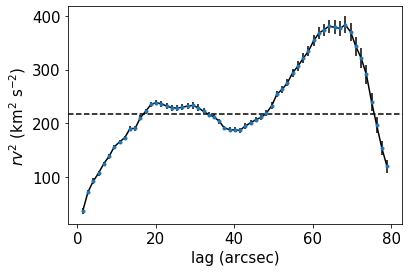

In [18]:
plt.plot(sf['Lag'],sf['Nmqvd'],color='k', alpha=1)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.axhline(y=sig2, color='k', linestyle='--')
plt.ylabel(r'$rv^2\ (\mathrm{km^2\ s^{-2}})$')
plt.xlabel('lag (arcsec)')

Text(0.5, 0, 'lag (arcsec)')

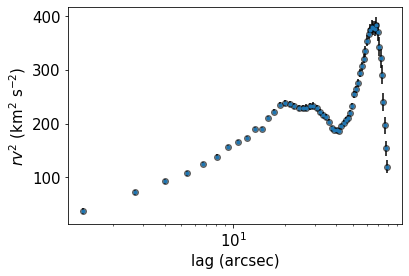

In [19]:
plt.scatter(sf['Lag'],sf['Nmqvd'],color='k', alpha=0.5)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.xscale("log")
plt.ylabel(r'$rv^2\ (\mathrm{km^2\ s^{-2}})$')
plt.xlabel('lag (arcsec)')

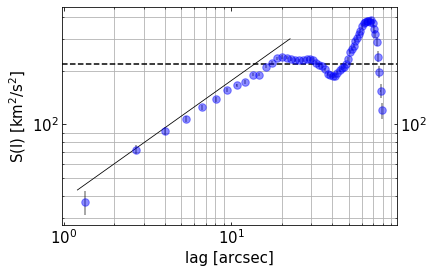

In [34]:
fig, ax=plt.subplots()
ax.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt="o",color='b', ecolor='k', alpha=0.45, markersize=7.5)
ax.set(xscale='log',yscale='log')
ax.axhline(y=sig2, color='k', linestyle='--')
sgrid = np.logspace(.08, 1.35)
ax.plot(sgrid, 38.0*sgrid**(2/3), color="k", lw=0.8)
ax.set(xlabel='lag [arcsec]', ylabel=r'S(l) [km$^{2}$/s$^{2}$]')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid(which='minor')
